### En el grupo está cómo calculé estas functiones

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
g = 9.81 * 100 / (1000 * 1000) # m/s^2 a cm/(ms^2)

def get_mu_d(a, M, m, g=g):
    return (2*a+M*g)/(m*g)

def get_error_mu_d(a, M, m, da, dM, dm, g=g):
    return (2*(1 - dm * g) * a + (1 - dm * g) * M * g + 2 * da + dM * g) / (dm*m*g*g)

In [5]:
TRINEO = 110 # g
DTRINEO = 1 # g

PLATA = 23 # g
DPLATA = 1 # g

MADERA = 6 # g
DMADERA = 1 # g

ORO = 72 # g
DORO = 1 # g

### Mu dinámico para Mesa

In [6]:
# Dos Plata y Madera Arriba, Oro Abajo
m1 = 2 * PLATA + MADERA + TRINEO
dm1 = 2 * DPLATA + DMADERA + DTRINEO
M1 = ORO
dM1 = DORO

# Intento 1
a11 = 1.19 * 10**(-5)
da11 = 4.9 * 10**(-6)

# Intento 2
## FIX DATA

# Madera y Oro Arriba, Dos Plata Abajo
m2 = MADERA + ORO + TRINEO
dm2 = DMADERA + DORO + DTRINEO
M2 = 2 * PLATA
dM2 = 2 * DPLATA

# Intento 1
a21 = 1.66 * 10**(-5)
da21 = 9.46 * 10**(-7)



In [11]:
def plot_mus_d_with_error_bar(mus_d, sigmas_mus_d):
    fig, ax = plt.subplots()

    ax.errorbar(range(len(mus_d)), mus_d, yerr=sigmas_mus_d, fmt='o')
    ax.set_xlabel('Intento')
    ax.set_ylabel('$\mu_d$')
    
    # Set x-axis ticks to be integers
    ax.set_xticks(range(len(mus_d)))
    
    plt.show()

<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
C:\Users\xxx\AppData\Local\Temp\ipykernel_10156\2710081417.py:6: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('$\mu_d$')


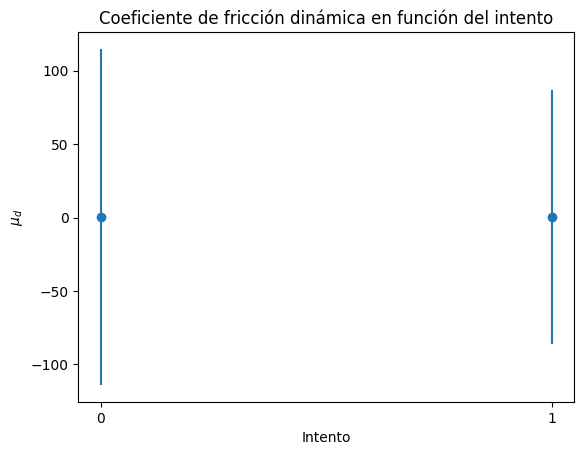

In [10]:
# HACER ESTO PARA CADA TIPO DE SUPERFICIE   
mus_d = [get_mu_d(a11, M1, m1), get_mu_d(a21, M2, m2)]
sigmas_mus_d = [get_error_mu_d(a11, M1, m1, da11, dM1, dm1), get_error_mu_d(a21, M2, m2, da21, dM2, dm2)]

plot_mus_d_with_error_bar(mus_d, sigmas_mus_d)